In [526]:
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import gc


# 폰트 설정
try:
    plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
except:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        plt.rcParams['font.family'] = 'AppleGothic'

plt.rcParams['axes.unicode_minus'] = False
fm._load_fontmanager(try_read_cache=False)


# 디바이스 설정
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps") # 맥
elif torch.cuda.is_available():
    device = torch.device("cuda:0") # 윈도우
else:
    device = torch.device("cpu")


# 디바이스 설정
def clean_cache():
    gc.collect()
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()

clean_cache()

In [505]:
import glob

DATA_PATH = "./data"
TRAIN_NORMAL_PATHS = sorted(glob.glob("./data/train/NORMAL/*.jpeg"))
TRAIN_TARGET_PATHS = sorted(glob.glob("./data/train/PNEUMONIA/*.jpeg"))
VAL_NORMAL_PATHS = sorted(glob.glob("./data/val/NORMAL/*.jpeg"))
VAL_TARGET_PATHS = sorted(glob.glob("./data/val/PNEUMONIA/*.jpeg"))
TEST_NORMAL_PATHS = sorted(glob.glob("./data/test/NORMAL/*.jpeg"))
TEST_TARGET_PATHS = sorted(glob.glob("./data/test/PNEUMONIA/*.jpeg"))

PATHS_LIST = [TRAIN_NORMAL_PATHS, TRAIN_TARGET_PATHS, VAL_NORMAL_PATHS, VAL_TARGET_PATHS, TEST_NORMAL_PATHS, TEST_TARGET_PATHS]
PATHS_DICT = {"TRAIN NORMAL": TRAIN_NORMAL_PATHS,
              "TRAIN TARGET": TRAIN_TARGET_PATHS,
              "VAL NORMAL": VAL_NORMAL_PATHS,
              "VAL TARGET": VAL_TARGET_PATHS,
              "TEST NORMAL": TEST_NORMAL_PATHS,
              "TEST TARGET": TEST_TARGET_PATHS}

print("[데이터 개수]")
for name, path in PATHS_DICT.items():
    print(f"· {name}: {len(path)}개")

[데이터 개수]
· TRAIN NORMAL: 1341개
· TRAIN TARGET: 3875개
· VAL NORMAL: 8개
· VAL TARGET: 8개
· TEST NORMAL: 234개
· TEST TARGET: 390개


1. 사이즈 편차가 심하다.

2. 학습 데이터는 많다.

3. 검증 데이터 개수가 적다.

In [506]:
import os

all_folders = [set(os.listdir("./data/train/NORMAL")), 
                set(os.listdir("./data/train/PNEUMONIA")),
                set(os.listdir("./data/val/NORMAL")),
                set(os.listdir("./data/val/PNEUMONIA")),
                set(os.listdir("./data/test/NORMAL")),
                set(os.listdir("./data/test/PNEUMONIA"))]

count = 0
tmp_set = set()

for folder in all_folders:
    for file_name in folder:
        if ".jpeg" in file_name:
            tmp_set.add(file_name)
            count += 1

print(f"전체 중 중복 파일: {count - len(tmp_set)}개")

전체 중 중복 파일: 0개


In [507]:
import random
import torchvision

rand_index = random.randint(0, len(TRAIN_NORMAL_PATHS))

sample_normal_image = TRAIN_NORMAL_PATHS[rand_index]
sample_normal_image = torchvision.io.read_image(sample_normal_image)[0]

print(f"[샘플 이미지 정보]")
print(f"· 사이즈: {sample_normal_image.shape}")
print(f"· 클래스: {type(sample_normal_image)}")
print(f"· 데이터: {sample_normal_image.dtype}")


[샘플 이미지 정보]
· 사이즈: torch.Size([1433, 1636])
· 클래스: <class 'torch.Tensor'>
· 데이터: torch.uint8


- 텐서 타입

- uint8 타입

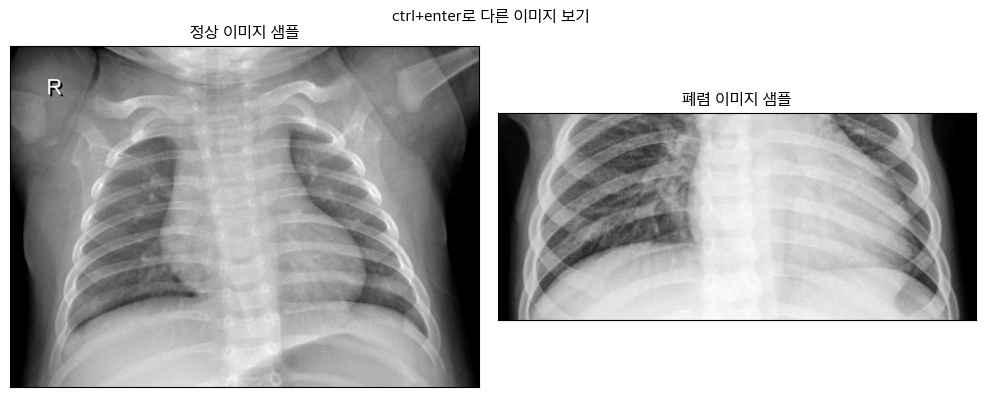

In [508]:
import torchvision
import matplotlib.pyplot as plt

rand_index = random.randint(0, len(TRAIN_NORMAL_PATHS))

sample_normal_image = TRAIN_NORMAL_PATHS[rand_index]
sample_target_image = TRAIN_TARGET_PATHS[rand_index]

sample_normal_image = torchvision.io.read_image(sample_normal_image)
sample_target_image = torchvision.io.read_image(sample_target_image)


# 축 숫자 표기 제거 함수 생성
def remove_ticks(columns=2):
    for num in range(columns):
        axes[num].set_xticks([])
        axes[num].set_yticks([])


# 샘플 이미지 출력
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
remove_ticks()

axes[0].imshow(sample_normal_image[0], cmap="gray")
axes[1].imshow(sample_target_image[0], cmap="gray")

fig.suptitle("ctrl+enter로 다른 이미지 보기")
axes[0].set_title("정상 이미지 샘플")
axes[1].set_title("폐렴 이미지 샘플")

plt.tight_layout()
plt.show()

- 폐렴 환자의 사진이 전반적으로 더욱 뿌옇다는 사실을 알 수 있다.

- 사진 각각의 사이즈가 모두 다르다는 것을 알 수 있다. 이는 사전 학습 모델이 사이즈 조절을 하므로 그대로 진행한다.

In [527]:
# # 사이즈 편차 확인

# max_w = 0
# min_w = 10000000
# max_h = 0
# min_h = 10000000

# print("[사이즈 구성]")

# for name, PATH in PATHS_DICT.items():

#     size_set = set()
#     h_size_set = set()
#     w_size_set = set()

#     for image in PATH:
#         image = torchvision.io.read_image(image)[0]

#         size_set.add(image.shape)
#         h_size_set.add(image.shape[0])
#         w_size_set.add(image.shape[1])
    
#     print(f"· {name}: 총 {len(size_set)} 종류")
#     max_w = max(max_w, max(w_size_set))
#     max_h = max(max_h, max(h_size_set))
#     min_w = min(min_w, min(w_size_set))
#     min_h = min(min_h, min(h_size_set))

# print(f"(최대 W: {max_w}, 최소 W: {min_w}, 최대 H: {max_h}, 최소 H: {min_h})")

모델 선정

1. 분류에 특화되어 있을 것. 일단 분류니까 시그모이드.

2. 손실: 0과 1 사이니까 MSE 또는 RMSLE. 혹은 크로스엔트로피\

현재 학습 데이터는 흑백의 1채널로, ResNet 모델의 3채널과 맞지 않는다.

해결 방안

1. 변환기와 conv1의 입력 채널을 3에서 1로 수정한다.

2. 학습 데이터를 3채널로 변환한다.

이 두 가지 방안을 각각 실험하는 방향으로 진행한다.

In [510]:
from torchvision.transforms import v2
from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# device 설정
channel_1_device = device
channel_3_device = device


# 사전 학습 모델(ResNet152)
channel_1_model = torchvision.models.resnet152(weights='IMAGENET1K_V1')
channel_3_model = torchvision.models.resnet152(weights='IMAGENET1K_V1')


# 기존 변환기 수정(3채널 -> 1채널)  * 참고 자료: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html#torchvision.models.ResNet152_Weights
channel_1_transform = v2.Compose([
        v2.Grayscale(num_output_channels=1), # 입력 채널이 1개이므로 변경.
        v2.Resize(256, interpolation=InterpolationMode.BILINEAR),
        v2.CenterCrop(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.449], # 기존 3채널 값의 평균값 활용
                     std=[0.226])])

channel_3_transform = torchvision.models.ResNet152_Weights.IMAGENET1K_V1.transforms()

channel_1_train_dataset = ImageFolder(root = "./data/train", transform=channel_1_transform)
channel_3_train_dataset = ImageFolder(root = "./data/train", transform=channel_3_transform)

# 데이터 로더 설정
channel_1_train_dataloader = DataLoader(channel_1_train_dataset, batch_size=64, shuffle=True)
channel_1_image, channel_1_label = next(iter(channel_1_train_dataloader))

channel_3_train_dataloader = DataLoader(channel_3_train_dataset, batch_size=64, shuffle=True)
channel_3_image, channel_3_label = next(iter(channel_3_train_dataloader))

## 3채널 모델

In [511]:
# 모델의 주요 레이어 확인
print("[ResNet152 주요 레이어]")

for n, (name, module) in enumerate(channel_3_model.named_children()):
    print(f"{n}) {name}: {module.__class__.__name__}")

[ResNet152 주요 레이어]
0) conv1: Conv2d
1) bn1: BatchNorm2d
2) relu: ReLU
3) maxpool: MaxPool2d
4) layer1: Sequential
5) layer2: Sequential
6) layer3: Sequential
7) layer4: Sequential
8) avgpool: AdaptiveAvgPool2d
9) fc: Linear


In [512]:
# 입력과 출력층
print(f"· 입력층: {channel_3_model.conv1}")
print(f"· 출력층: {channel_3_model.fc}")

· 입력층: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
· 출력층: Linear(in_features=2048, out_features=1000, bias=True)


 conv1 → (1, 64, 112, 112)


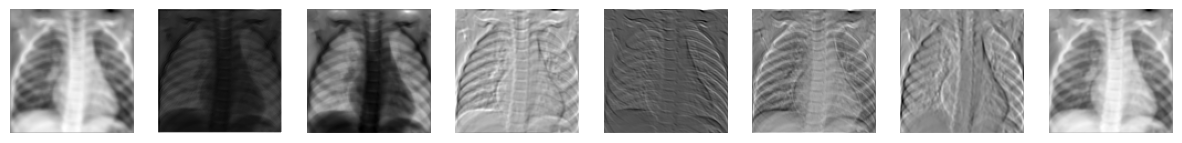

 layer1 → (1, 256, 112, 112)


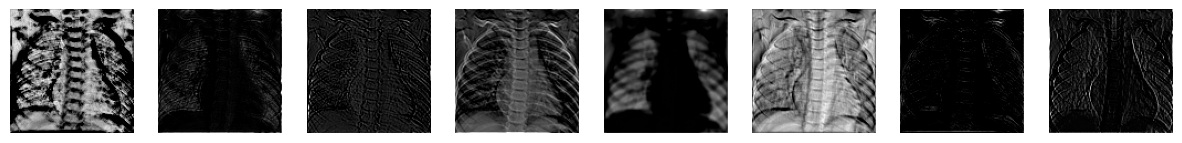

 layer2 → (1, 512, 56, 56)


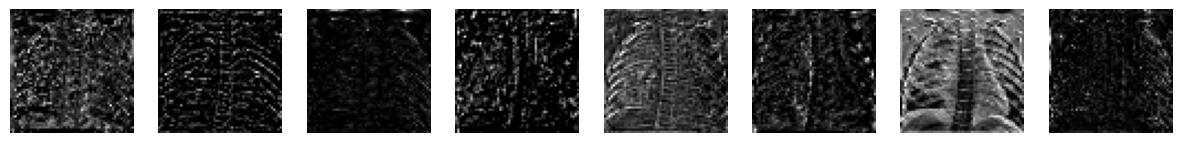

 layer3 → (1, 1024, 28, 28)


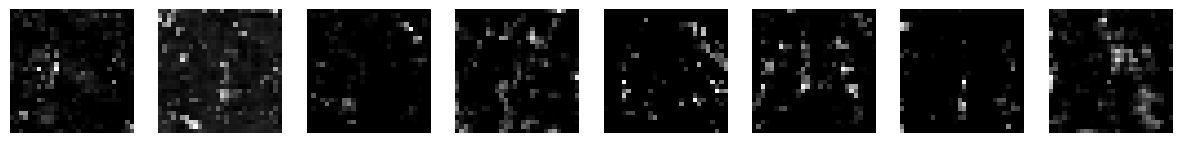

 layer4 → (1, 2048, 14, 14)


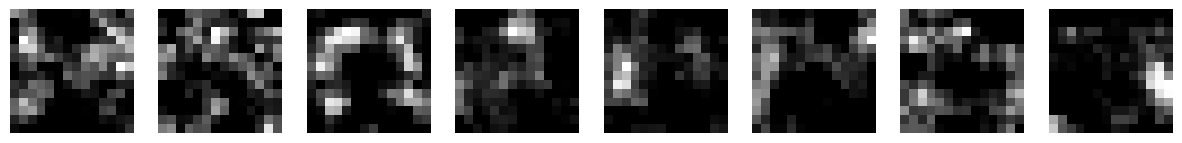

In [513]:
channel_3_sample_image = channel_3_train_dataset[0][0]

x = channel_3_transform(channel_3_sample_image).unsqueeze(0)
layers = dict(channel_3_model.named_children())

def show_feature(name, out, max_channels=8):
    fmap = out.squeeze(0).detach().cpu()
    num = min(max_channels, fmap.shape[0])
    fig, axes = plt.subplots(1, num, figsize=(15,4))

    for i, ax in enumerate(axes if num>1 else [axes]):
        ax.imshow(fmap[i], cmap="gray")
        ax.axis("off")

    print(f" {name} → {tuple(out.shape)}")
    # axes[0].set_title(f"{name} → {tuple(out.shape)}", fontsize=10, loc="left")
    plt.show()

out = x
for name in ["conv1", "layer1", "layer2","layer3","layer4"]:
    out = layers[name](out)
    show_feature(name, out)

layer2까지는 살리고 3부터는 재학습.

In [514]:
import torch.nn as nn

# 출력층 수정:  클래스 개수에 맞게 fc 수정(0, 1)
in_features = channel_3_model.fc.in_features
channel_3_model.fc = nn.Linear(in_features=in_features, out_features=2)


# 레이어 학습, 동결 구분
for name, param in channel_3_model.named_parameters():
    if name.startswith(("layer3", "layer4", "fc")):
        param.requires_grad = True # 안 쓰겠다. 즉, 재학습시키겠다. 역전파에 참여시키겠다.
    else:
        param.requires_grad = False # 쓰겠다. 재학습시키지 않겠다. 역전파 시키지 않겠다.


channel_3_model = channel_3_model.to(channel_3_device)

## 1채널 모델

In [515]:
# 모델의 주요 레이어 확인
print("[ResNet152 주요 레이어]")

for n, (name, module) in enumerate(channel_1_model.named_children()):
    print(f"{n}) {name}: {module.__class__.__name__}")

[ResNet152 주요 레이어]
0) conv1: Conv2d
1) bn1: BatchNorm2d
2) relu: ReLU
3) maxpool: MaxPool2d
4) layer1: Sequential
5) layer2: Sequential
6) layer3: Sequential
7) layer4: Sequential
8) avgpool: AdaptiveAvgPool2d
9) fc: Linear


In [516]:
# 입력과 출력층
print(f"· 입력층: {channel_1_model.conv1}")
print(f"· 출력층: {channel_1_model.fc}")

· 입력층: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
· 출력층: Linear(in_features=2048, out_features=1000, bias=True)


In [517]:
import torch.nn as nn

# 기존 conv1(입력 레이어)의 가중치(3채널)을 1채널화
old_weights = channel_1_model.conv1.weight.data
channel_1_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 시그모이드로 하는 건 여기가 아닌가?
with torch.no_grad():
    channel_1_model.conv1.weight.data = old_weights.mean(dim=1, keepdim=True)


# 출력층 수정:  클래스 개수에 맞게 fc 수정(0, 1)
in_features = channel_1_model.fc.in_features
channel_1_model.fc = nn.Linear(in_features=in_features, out_features=2)


# 레이어 학습, 동결 구분
for name, param in channel_1_model.named_parameters():
    if name.startswith(( "conv1", "layer3", "layer4", "fc")): # conv1도 재학습 필요.
        param.requires_grad = True # 안 쓰겠다. 즉, 재학습시키겠다. 역전파에 참여시키겠다.
    else:
        param.requires_grad = False # 쓰겠다. 재학습시키지 않겠다. 역전파 시키지 않겠다.


channel_1_model = channel_1_model.to(channel_3_device)

 conv1 → (1, 64, 112, 112)


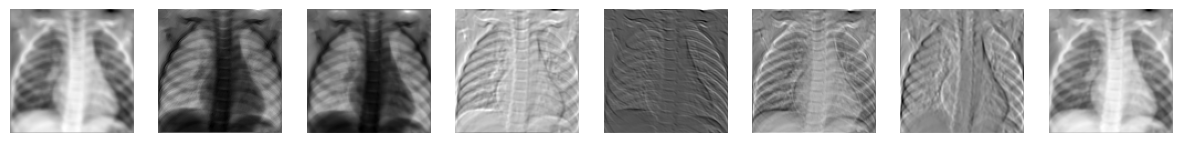

 layer1 → (1, 256, 112, 112)


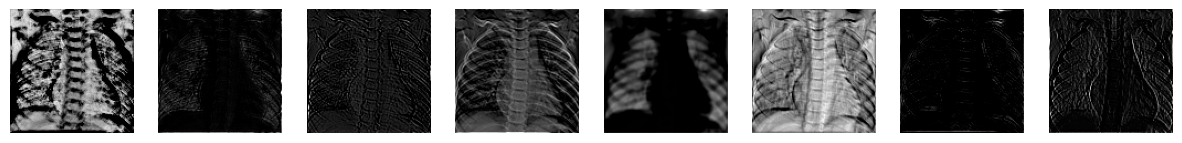

 layer2 → (1, 512, 56, 56)


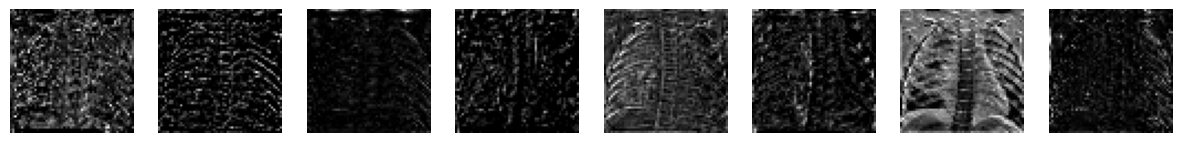

 layer3 → (1, 1024, 28, 28)


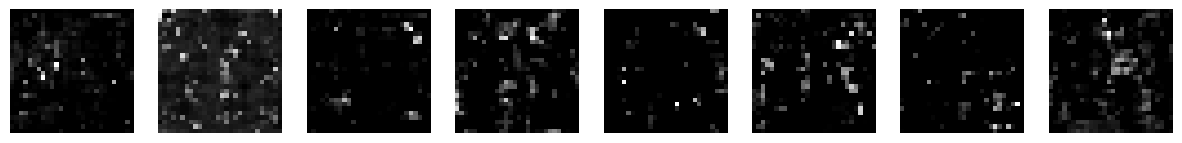

 layer4 → (1, 2048, 14, 14)


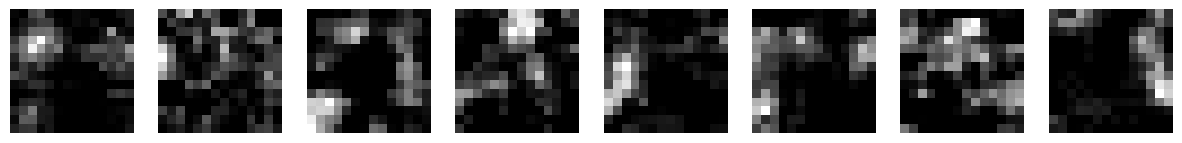

In [519]:
channel_1_sample_image = channel_1_train_dataset[0][0].to(channel_3_device)

x = channel_1_transform(channel_1_sample_image).unsqueeze(0)
layers = dict(channel_1_model.named_children())

out = x
for name in ["conv1", "layer1", "layer2","layer3","layer4"]:
    out = layers[name](out)
    show_feature(name, out)